In [1]:
%matplotlib inline

# Create a spreadsheet (dataset) of features from an image

## Author: Dr Franck P. Vidal, Bangor University
For this example, we use a radiograph pf a block of plexiglass. The image is stored in a DICOM file. Each pixel is stored using an unsigned integer (14 bits). We use *SimpleITK* to load the data. Uncomment the line below if you need to install it.

In [1]:
# !pip install --user simpleitk

## What is a data set (also called dataset)

Before you carry on, it is important that you get familiar with *Lecture 2* about **Data**, in particular Slide 4.

![Slide 4 of Lecture 2 on "Data"](img/lect2-slide4.png)

A dataset is often represented as a matrix that can be saved in a spreadsheet. 
Notice the notation below:
    
- **Z** is the dataset. 
- Each row is an **object**.
- There are *N* objects in **Z**.
- Each column (except the last one) is a feature.
- There are *n* features.
- The last column (*y*) stores the label of each object.
- There are *c* classes.

As you must have noticed, Question 1(d) of the assignment is related to this notation.

In [2]:
import os
import random
import numpy as np
import pandas as pd

from scipy.stats import kurtosis
from scipy.stats import skew

from ipywidgets import Button, HBox
import functools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 12.5
       }
matplotlib.rc('font', **font)

import SimpleITK as sitk # Load the medical DICOM file

# Load an image

SimpleITK is used to open the image. The data must be converted into a numpy array.

In [4]:
fname = "../../Labs/Lab-01/DX000000"

reader = sitk.ImageFileReader()
# reader.SetImageIO("GDCMImageIO")
reader.SetFileName(fname)
# reader.LoadPrivateTagsOn()
# reader.ReadImageInformation()    
sitk_volume = reader.Execute()
np_image = sitk.GetArrayFromImage(sitk_volume)[0]

# Standardisation

We use the zero-mean, unit variance normalisation (also called standardisation) method so that that the average pixel value of the whole image is 0, and the standard deviation 1.

In [5]:
bias = -np.mean(np_image)
gain = 1.0 / np.std(np_image)

In [6]:
def applyBiasGain(data):
    return (data + bias) * gain

In [7]:
np_image = applyBiasGain(np_image.astype(np.single))

# Display the image

In [8]:
spacing = sitk_volume.GetSpacing()[0:2]
size = sitk_volume.GetSize()[0:2]

print("Image size:", size, "[px]")
print("Pixel spacing:", spacing, "[mm]")

Image size: (3040, 2442) [px]
Pixel spacing: (0.14, 0.14) [mm]


In [9]:
window_centre = int(sitk_volume.GetMetaData("0028|1050"))
window_width = int(sitk_volume.GetMetaData("0028|1051"))

print("Window Center used: ", window_centre)
print("Window Width used: ", window_width)

vmin = applyBiasGain(window_centre - window_width / 2)
vmax = applyBiasGain(window_centre + window_width / 2)

view_position = sitk_volume.GetMetaData("0018|5101")
print("View position: ", view_position)

Window Center used:  8192
Window Width used:  16383
View position:  AP


Plot the image

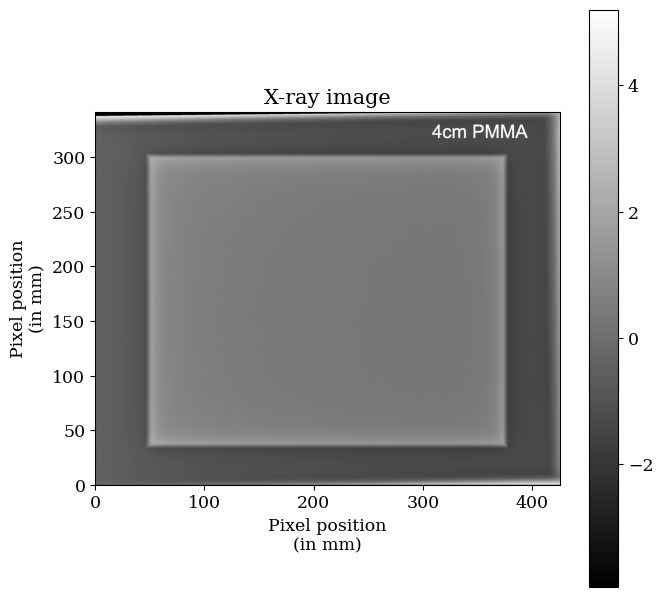

In [10]:
plt.figure(figsize= (7.5,7.5))
xrange = range(np_image.shape[1])
yrange = range(np_image.shape[0])

extent = [0,(np_image.shape[1]-1)*spacing[0],0,(np_image.shape[0]-1)*spacing[1]]
plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image")
plt.imshow(np_image, cmap="gray", 
           vmin=vmin, vmax=vmax,
           extent=extent)
plt.colorbar(orientation='vertical')
plt.show()

# List of some possible features

<!-- 1. Split the image in small $l\times l$ tiles, e.g. with $l=10$; -->
1. Decide what the classes are:
    - `1` for the background,
    - `2` for the foreground.
2. For each object, extract features, e.g. statistic values on the pixel values of the tile:
    - Average pixel value,
    - Median pixel value,
    - Standard deviation,
    - Min pixel value,
    - Max pixel value,
    - Kurtosis, and 
    - Skewness.
    
    (others could be used)

# Create a dataset

We must create a spreadsheet. Below are the columns of the spreadsheet.

In [11]:
columns = ["x", "y", "length of tile size [in px]", "avg", "median", "stddev", "kurtosis", "skewness", "c"]
rows = []

In [12]:
def getRecord(x, y, tile_lenght, tile, switch):
    row = []
    
    row.append(x)
    row.append(y)
    row.append(tile_lenght)
    row.append(np.mean(tile))
    row.append(np.median(tile))
    row.append(np.std(tile))
    row.append(kurtosis(tile, axis=None))
    row.append(skew(tile, axis=None))
    
    # Background
    if switch[0].style.button_color == 'pink':
        row.append(1)
    # Foreground
    else:
        row.append(2)
    
    return row

In [13]:
def upon_clicked(btn, _rs):
    global rows
    
    label = btn[0]
    x = btn[1]
    y = btn[2]
    tile_lenght = btn[3]
    tile = btn[4]
    switch = btn[5]

    switch[1 - label].style.button_color = 'gray'
    switch[label].style.button_color = 'pink'

    rows.append(getRecord(x, y, tile_lenght, tile, switch))
    
def getTile(image: np.array, vmin: int, vmax: int, extent, tile_lenght: int=10):


    # Handle the border
    x = random.randint(0, image.shape[1] - 1 - tile_lenght)
    y = random.randint(0, image.shape[0] - 1 - tile_lenght)
    tile = image[y:y+tile_lenght, x:x+tile_lenght];
    
    plt.figure()
    ax = plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    rect = patches.Rectangle((x, y), 
                             tile_lenght, tile_lenght, 
                             linewidth=1, edgecolor='r', facecolor='none');
    ax.add_patch(rect)

    # ax = plt.subplot(1, 2, 2)
    # plt.imshow(tile, cmap="gray", vmin=vmin, vmax=vmax)
    plt.show();
    
    switch = [Button(description=name) for name in ["Background", "Foreground"]]
    combined = HBox([items for items in switch])
    
    switch[0].on_click(functools.partial(upon_clicked, [0, x, y, tile_lenght, tile, switch]))
    switch[1].on_click(functools.partial(upon_clicked, [1, x, y, tile_lenght, tile, switch]))

    display(combined)

# Display the image $N$ times and select the class

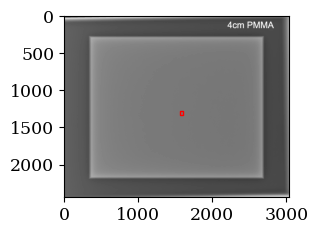

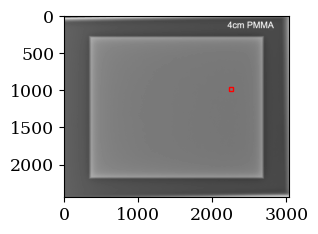

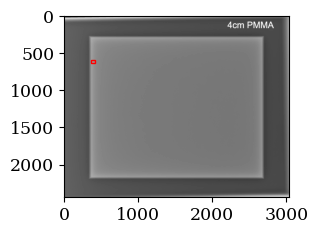

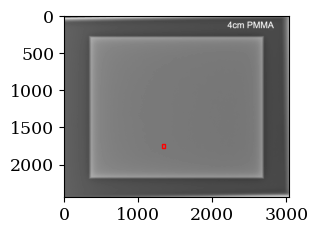

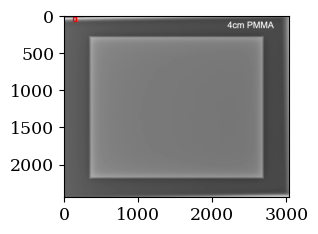

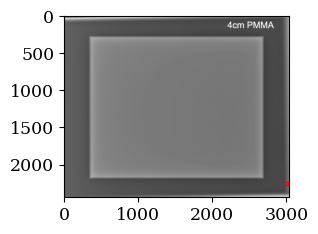

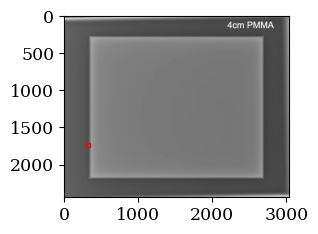

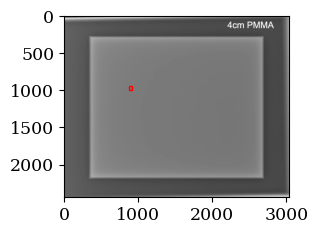

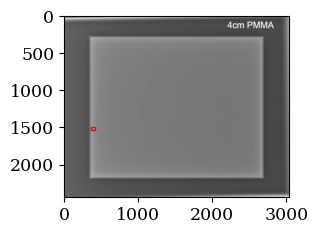

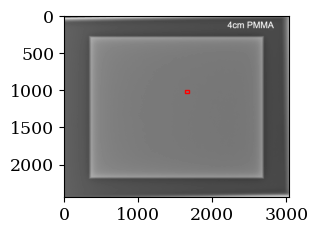

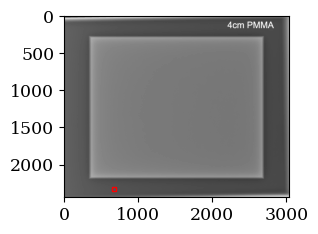

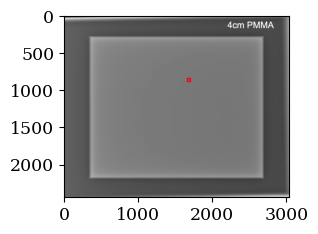

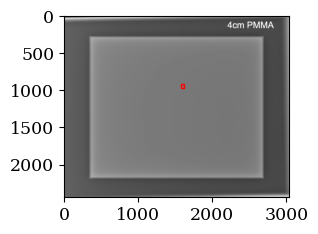

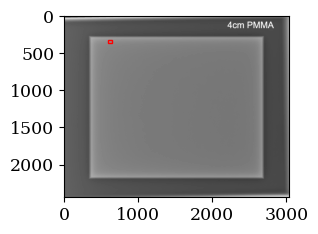

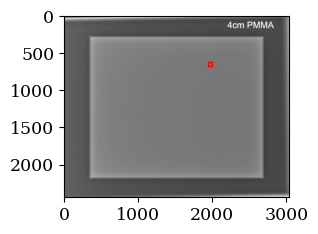

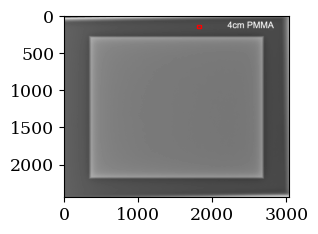

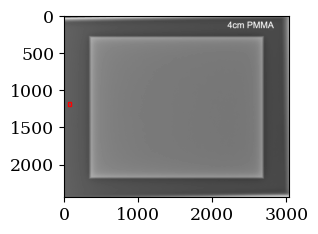

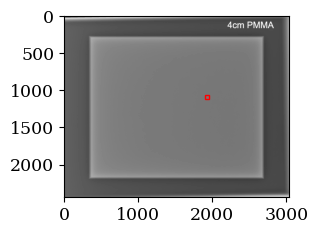

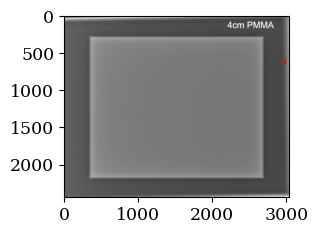

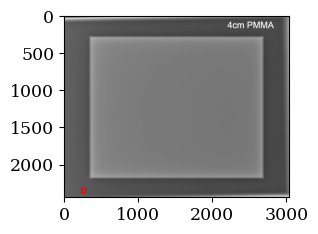

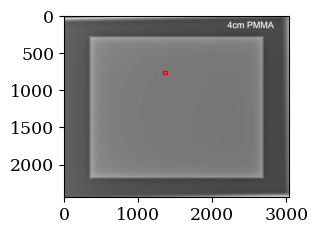

In [14]:
for i in range(21):
    getTile(np_image, vmin, vmax, extent, 50)

In [20]:
print(len(rows), "objects in the dataset")

22 objects in the dataset


# Save the dataset in a file

Create the dataframe

In [21]:
df = pd.DataFrame(columns=columns, data=rows)

In [22]:
df.to_csv("dataset.csv", index=False)

In [23]:
display(df)

,x,y,length of tile size [in px],avg,median,stddev,kurtosis,skewness,c
0,1561,1277,50,0.351310,0.350828,0.018950,-0.477596,0.016406,2
1,2230,961,50,0.315120,0.315080,0.018807,-0.572361,0.091526,2
2,368,587,50,1.460836,1.439744,0.189482,-1.206975,0.213772,2
3,1320,1722,50,0.411507,0.412270,0.018335,-0.520053,-0.037214,2
4,117,14,50,0.692839,2.289596,3.404967,-1.546484,-0.546712,1
5,2975,2230,50,-0.424341,-0.474168,0.489323,-1.062667,0.306800,1
6,307,1708,50,-0.627581,-1.024072,0.611619,-0.554643,0.948299,2
7,873,942,50,0.503006,0.502757,0.017954,-0.528245,0.153976,2
8,366,1489,50,1.432037,1.423266,0.183619,-1.249475,0.096541,2
9,1634,991,50,0.355340,0.355296,0.018045,-0.404906,0.039975,1


In [24]:
print("Number of objects corresponding to the foreground:", df[df["c"]==2]["c"].count())
print("Number of objects corresponding to the background:", df[df["c"]==1]["c"].count())

Number of objects corresponding to the foreground: 14
Number of objects corresponding to the background: 8
